In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Conversion constant: from milli-g to m/s²
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Rename columns: input data has columns: time, x, y, z
    data = data.rename(columns={'time': 't', 'x': 'ax', 'y': 'ay', 'z': 'az'})
    
    # Convert time to seconds
    data['t'] = data['t'] / 1000.0
    
    # Remove any NaN entries
    data = data.dropna()
    
    # Convert acceleration from mg to m/s²
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers: if the absolute ratio to the median exceeds threshold, replace with median.
    for acc in ['ax', 'ay', 'az']:
        median_val = np.median(data[acc])
        # Use a threshold to decide what constitutes an outlier.
        if median_val != 0:
            outlier_idx = np.abs(data[acc] / median_val) > 1.5
            data.loc[outlier_idx, acc] = median_val

    # Compute velocity by integrating acceleration over time.
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial=0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial=0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial=0)

    # Compute position by integrating velocity over time.
    data['x_pos'] = cumulative_trapezoid(data['vx'], data['t'], initial=0)
    data['y_pos'] = cumulative_trapezoid(data['vy'], data['t'], initial=0)
    data['z_pos'] = cumulative_trapezoid(data['vz'], data['t'], initial=0)
    
    return data



In [73]:
# Read and preprocess the dataset.
# Replace "data/trial1.csv" with the correct path if needed.
data = pd.read_csv("data/trial1.csv")
data = process_data(data)
data.head()


,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos
0,0.105,-0.784532,4.707192,-9.139798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.207,-0.509946,4.354153,-9.139798,-0.066018,0.462129,-0.932259,-0.003367,0.023569,-0.047545
2,0.308,-0.235360,4.118793,-9.061345,-0.103656,0.890012,-1.851417,-0.011936,0.091852,-0.188121
3,0.411,-0.274586,4.432606,-9.100571,-0.129918,1.330409,-2.786756,-0.023965,0.206203,-0.426987
4,0.512,-0.353039,4.275699,-9.218251,-0.161614,1.770179,-3.711856,-0.038687,0.362783,-0.755167


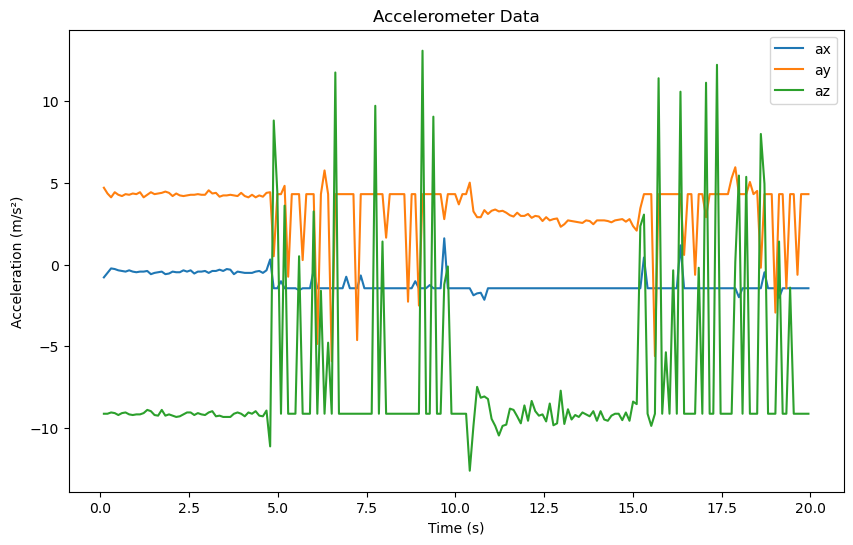

In [74]:
# Visualize the acceleration signals.
plt.figure(figsize=(10, 6))
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label=acc)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Data")
plt.legend()
plt.show()


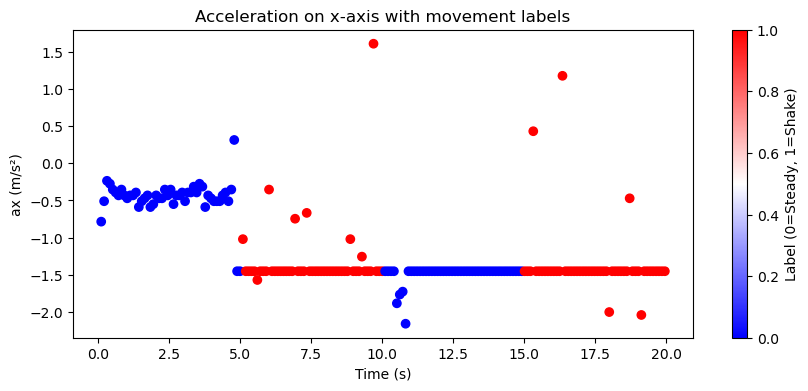

,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos,label,acc_mag,vel_mag,pos_mag
86,8.873,-1.019892,4.314926,-9.139798,-7.525996,32.787024,-67.356348,-23.990949,154.446422,-317.317704,1,10.158478,75.289489,353.722756
10,1.122,-0.431493,4.432606,-9.179024,-0.412880,4.394340,-9.297136,-0.211265,2.238092,-4.720180,0,10.202385,10.291619,5.228173
51,5.294,-1.451384,-0.745305,-9.139798,-2.606921,21.712237,-43.222065,-5.914728,57.836318,-121.999805,1,9.284282,48.439283,135.144279
81,8.359,-1.451384,4.314926,-9.139798,-6.801991,31.247929,-62.658492,-20.304123,137.954142,-283.903890,1,10.210828,70.347614,316.298943
126,12.968,-1.451384,2.314369,-7.727640,-13.293483,46.359506,-99.309022,-66.200346,317.795602,-649.556339,0,8.196295,110.400192,726.154232


In [75]:


# Label the data based on the movement sequence.
# According to the experiment:
#   - 0 ≤ t < 5 s: Steady (label 0)
#   - 5 ≤ t < 10 s: Shaken (label 1)
#   - 10 ≤ t < 15 s: Steady (label 0)
#   - 15 ≤ t < 20 s: Shaken (label 1)
def label_motion(t):
    if 0 <= t < 5:
        return 0
    elif 5 <= t < 10:
        return 1
    elif 10 <= t < 15:
        return 0
    elif 15 <= t < 20:
        return 1
    else:
        return np.nan

data['label'] = data['t'].apply(label_motion)
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

data['acc_mag'] = np.sqrt(data['ax']**2 + data['ay']**2 + data['az']**2)
data['vel_mag'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)
data['pos_mag'] = np.sqrt(data['x_pos']**2 + data['y_pos']**2 + data['z_pos']**2)

plt.figure(figsize=(10, 4))
plt.scatter(data['t'], data['ax'], c=data['label'], cmap='bwr', label="ax")
plt.xlabel("Time (s)")
plt.ylabel("ax (m/s²)")
plt.title("Acceleration on x-axis with movement labels")
plt.colorbar(label="Label (0=Steady, 1=Shake)")
plt.show()

data.sample(5)

In [76]:
feature_cols = ['ax', 'ay', 'az', 'acc_mag', 'vel_mag', 'pos_mag']
X = data[feature_cols]
y = data['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


Number of training samples: 136
Number of testing samples: 59


In [77]:

# Train a logistic regression model.
# The model fits the following relationship:
#   p = σ(b0 + b1*t + b2*ax + b3*ay + b4*az)
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set and report accuracy.
preds = lr.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Classification Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed performance metrics.
print("\nClassification Report:")
print(classification_report(y_test, preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))


Classification Accuracy: 61.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63        28
           1       0.67      0.52      0.58        31

    accuracy                           0.61        59
   macro avg       0.62      0.62      0.61        59
weighted avg       0.62      0.61      0.61        59

Confusion Matrix:
[[20  8]
 [15 16]]


c:\Users\nolan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
